In [1]:
from py_wgpu_fdm import Simulation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation


In [13]:


COPPER_DENSITY = 8960.0  # kg / m^3

import numpy as np

def quat_from_frame(tangent, normal, binormal):
    """
    Convert an orthonormal frame to a quaternion.
    Frame columns are x=tangent, y=normal, z=binormal.
    """
    R = np.stack([tangent, normal, binormal], axis=1)  # 3x3 rotation matrix
    # Convert rotation matrix to quaternion
    q = np.empty(4)
    tr = np.trace(R)
    if tr > 0:
        S = np.sqrt(tr + 1.0) * 2
        q[3] = 0.25 * S
        q[0] = (R[2,1] - R[1,2]) / S
        q[1] = (R[0,2] - R[2,0]) / S
        q[2] = (R[1,0] - R[0,1]) / S
    else:
        if R[0,0] > R[1,1] and R[0,0] > R[2,2]:
            S = np.sqrt(1.0 + R[0,0] - R[1,1] - R[2,2]) * 2
            q[3] = (R[2,1] - R[1,2]) / S
            q[0] = 0.25 * S
            q[1] = (R[0,1] + R[1,0]) / S
            q[2] = (R[0,2] + R[2,0]) / S
        elif R[1,1] > R[2,2]:
            S = np.sqrt(1.0 + R[1,1] - R[0,0] - R[2,2]) * 2
            q[3] = (R[0,2] - R[2,0]) / S
            q[0] = (R[0,1] + R[1,0]) / S
            q[1] = 0.25 * S
            q[2] = (R[1,2] + R[2,1]) / S
        else:
            S = np.sqrt(1.0 + R[2,2] - R[0,0] - R[1,1]) * 2
            q[3] = (R[1,0] - R[0,1]) / S
            q[0] = (R[0,2] + R[2,0]) / S
            q[1] = (R[1,2] + R[2,1]) / S
            q[2] = 0.25 * S
    return q / np.linalg.norm(q)

def generate_helical_spring_frenet(
    spring_height: float,
    windings: int,
    helix_diameter: float = 0.015,
    wire_diameter: float = 0.01,
    nodes_per_winding: int = 4,
):
    """
    Generates a helical spring with edge quaternions aligned to the Frenet frame.
    """
    R = 0.5 * helix_diameter
    r = 0.5 * wire_diameter
    node_count = windings * nodes_per_winding + 1
    theta = np.linspace(0.0, 2.0 * np.pi * windings, node_count)
    x = np.linspace(0.0, spring_height, node_count)
    y = R * np.cos(theta)
    z = R * np.sin(theta)
    positions = np.stack([x, y, z], axis=1)

    # compute tangents
    tangents = np.zeros_like(positions)
    tangents[:-1] = positions[1:] - positions[:-1]
    tangents[-1] = tangents[-2]
    tangents = tangents / np.linalg.norm(tangents, axis=1, keepdims=True)

    # compute normals (derivative of tangent)
    dt = np.zeros_like(tangents)
    dt[1:-1] = tangents[2:] - tangents[:-2]
    dt[0] = tangents[1] - tangents[0]
    dt[-1] = tangents[-1] - tangents[-2]
    dt = dt / np.linalg.norm(dt, axis=1, keepdims=True)

    # binormal = tangent x normal
    binormals = np.cross(tangents, dt)
    binormals /= np.linalg.norm(binormals, axis=1, keepdims=True)

    # recompute normal = binormal x tangent to ensure orthonormality
    normals = np.cross(binormals, tangents)

    # create quaternions
    quaternions = np.array([quat_from_frame(t, n, b) for t, n, b in zip(tangents, normals, binormals)])

    return positions, quaternions




def add_center_z_velocity(nodes, num_nodes=20, mean=0.0, std=0.01):
    """
    Add Gaussian z-velocity to nodes near the center of the spring.

    nodes: list of [position, velocity] arrays
           velocity is a 3-vector [vx, vy, vz]
    num_nodes: number of nodes to perturb
    mean, std: Gaussian mean and std for the z-velocity
    """

    N = len(nodes)
    if num_nodes > N:
        raise ValueError("num_nodes cannot be larger than total nodes")

    # Pick central nodes
    center_idx = N // 2
    half_span = num_nodes // 2
    start = max(center_idx - half_span, 0)
    end = min(center_idx + half_span, N)

    # Generate Gaussian z-velocities
    vz = np.random.normal(loc=mean, scale=std, size=(end - start,))

    # Apply to the nodes
    for i, idx in enumerate(range(start, end)):
        nodes[idx][1][2] += vz[i]  # Add to z-component of velocity

    return nodes  # optional; modifies in-place


In [14]:
nodes, edges, dx, mass, inertia = generate_helical_spring(
    spring_height= 0.2,   # 5 cm
    windings=50,
    helix_diameter=0.015,
    wire_diameter=0.01,
    nodes_per_winding=8
)

nodes = add_center_z_velocity(nodes, mean=5.0)

In [15]:
import numpy as np
import matplotlib.pyplot as plt


def plot_spring(nodes, edges, show_nodes=True):
    """
    nodes: Vec<[[x,y,z], [vx,vy,vz]]>
    edges: Vec<([qx,qy,qz,qw], [mx,my,mz])>
    """

    positions = np.array([n[0] for n in nodes])

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    # Plot edges as a polyline
    ax.plot(
        positions[:, 0],
        positions[:, 1],
        positions[:, 2],
        lw=2,
        color="steelblue",
        label="Rod centerline",
    )

    # Plot nodes
    if show_nodes:
        ax.scatter(
            positions[:, 0],
            positions[:, 1],
            positions[:, 2],
            color="crimson",
            s=15,
            label="Nodes",
        )

    # Axis labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.set_title("Discretized Helical Spring (Initial Configuration)")
    ax.legend()

    # Equal aspect ratio (important!)
    max_range = (
        np.array([
            positions[:, 0].max() - positions[:, 0].min(),
            positions[:, 1].max() - positions[:, 1].min(),
            positions[:, 2].max() - positions[:, 2].min(),
        ]).max() / 2.0
    )

    mid = positions.mean(axis=0)

    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    plt.tight_layout()
    plt.show()


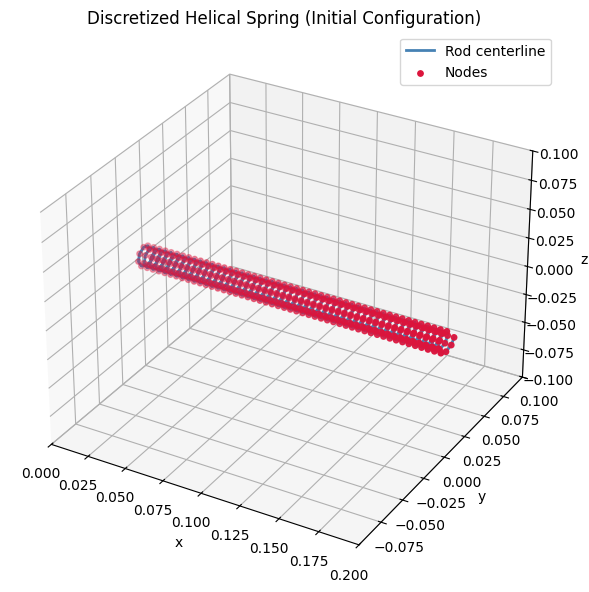

Discrete spring has 401 nodes


In [16]:
plot_spring(nodes, edges)
print(f'Discrete spring has {len(nodes)} nodes')

In [6]:
sim = Simulation(
    nodes=nodes,
    edges=edges,
    oversampling_factor=1,
    chunk_size=64,
    dt=1e-8,
    dx=dx,
    mass=mass,
    stiffness_se = [8.6e6, 3.2e6, 3.2e6],
    stiffness_bt = [4.0, 5.4, 5.4],
    inertia=inertia,
)


In [7]:
sim.initialize(0.0, 1)

Calling init!


In [8]:
for i in range(30000):
    sim.compute()

In [9]:
frames = sim.save()

In [10]:
import numpy as np
import matplotlib.pyplot as plt


def plot_spring_from_positions(positions, show_nodes=True):
    """
    positions: array-like of shape (N, 3)
               each entry is [x, y, z]
    """

    positions = np.asarray(positions)
    assert positions.ndim == 2 and positions.shape[1] == 3

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    # Connect nodes
    ax.plot(
        positions[:, 0],
        positions[:, 1],
        positions[:, 2],
        lw=2,
        color="steelblue",
        label="Spring centerline",
    )

    # Optional node markers
    if show_nodes:
        ax.scatter(
            positions[:, 0],
            positions[:, 1],
            positions[:, 2],
            color="crimson",
            s=15,
            label="Nodes",
        )

    # Labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title("Spring Configuration")

    # Equal aspect ratio (important!)
    max_range = np.ptp(positions, axis=0).max() / 2.0
    mid = positions.mean(axis=0)

    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    ax.legend()
    plt.tight_layout()
    plt.show()


In [11]:
p = [ n[0] for n in frames[-1] ]
p

[[0.0, 0.007499999832361937, 0.0],
 [0.037086132913827896, -0.006211458705365658, -0.47361743450164795],
 [-0.011371594853699207, 0.6765431761741638, -0.13997532427310944],
 [0.03592142090201378, 0.19168564677238464, 0.4629785418510437],
 [0.010357505641877651, 0.0219790730625391, 0.3530687391757965],
 [0.02011280506849289, -0.30677759647369385, 0.31403711438179016],
 [0.01829354837536812, -0.4208984076976776, -0.008448543027043343],
 [0.019154859706759453, -0.29518815875053406, -0.3013482689857483],
 [0.019640175625681877, 0.004727460443973541, -0.42131441831588745],
 [0.02010134793817997, 0.30183303356170654, -0.2951262891292572],
 [0.020592879503965378, 0.4212839603424072, 0.004723481833934784],
 [0.021084850654006004, 0.2951304316520691, 0.3018331229686737],
 [0.02163875848054886, -0.004723687656223774, 0.4212839603424072],
 [0.022229772061109543, -0.3018331229686737, 0.2951304316520691],
 [0.02270612306892872, -0.4212839603424072, -0.004723687656223774],
 [0.023414595052599907, -0

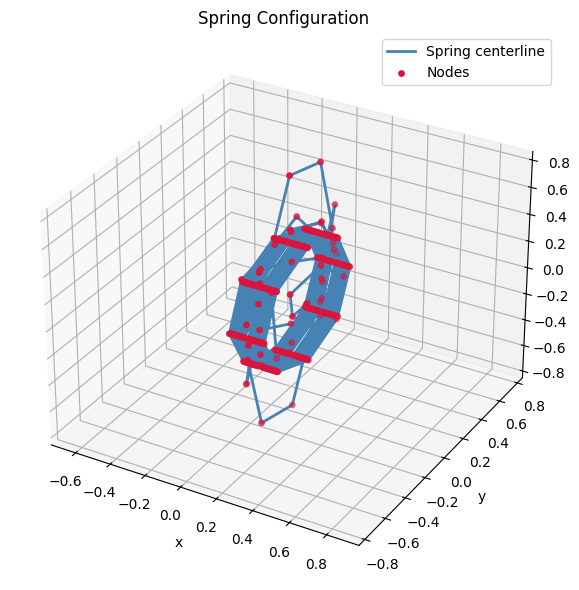

In [12]:
plot_spring_from_positions(p)